<a href="https://colab.research.google.com/github/Dirkster99/PyNotes/blob/master/Transformers/Issue/66_Transformer_4_Language_Classification_MultiLabel_electra_base_german_uncased_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.2.1

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 37.0MB/s 
     |████████████████████████████████| 890kB 36.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9271bfa21fcc8c30bde27ef10af842dcca929c8255780a729538e38900595cc3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Building a Language Classification Model with Transformers and TensorFlow 2.0

Original Author: James Briggs
https://www.youtube.com/watch?v=GYDFBfx8Ts8

Dataset: https://www.kaggle.com/dirkbahle/german-new-multilabel-multiclass-classification

## Download and Preprocessing Data

### 20 News Groups Categorization Dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
dataPath = '/gdrive/MyDrive/GermanDataSets/German_News_Dataset/'
!ls {dataPath.replace(' ', '\ ')}  -lha

total 330M
-rw------- 1 root root 241M Mar 18 11:08  archive.zip
-rw------- 1 root root 850K Mar 19 12:17 'German MultiClass Reformating.ipynb'
-rw------- 1 root root  89M Mar 18 17:19  German_News_MultiClass.zip
-rw------- 1 root root   49 Mar 18 11:56  readme.txt


In [4]:
import pandas as pd
df = pd.read_csv(dataPath+'German_News_MultiClass.zip')

In [5]:
df = df.dropna()

In [6]:
# Limit string length to conserve memory
df['text'] = df['text'].str.slice(0,3000)

In [7]:
#pd.set_option('display.max_colwidth', None)
df.head()

,Unnamed: 0,text,tags,Ausland,Deutschland,Wirtschaft,Panorama,Sport,Coronavirus,Berlin,Politik,news
0,0,Im Kreml sollte es in diesen Tagen eigentlich ...,"Ausland, „Sputnik V“",1,0,0,0,0,0,0,0,0
1,1,Der Preis setze ein Zeichen für die Millionen ...,"Ausland, Oslo",1,0,0,0,0,0,0,0,0
2,2,Die Kanzlerin berät mit den Bürgermeistern der...,"Deutschland, Corona-Pandemie",0,1,0,0,0,0,0,0,0
3,3,Anzeige\n\nDie Corona-Krise hat auch vor dem e...,"Wirtschaft, FIFA 21 im Test",0,0,1,0,0,0,0,0,0
4,4,Anzeige\n\nEin Problem? Kein Problem. Natürlic...,"Panorama, Popkultur",0,0,0,1,0,0,0,0,0


In [8]:
df.count()

Unnamed: 0     56609
text           56609
tags           56609
Ausland        56609
Deutschland    56609
Wirtschaft     56609
Panorama       56609
Sport          56609
Coronavirus    56609
Berlin         56609
Politik        56609
news           56609
dtype: int64

In [9]:
# drop rows without a single flag in it
indexNames = df[ (df['Ausland'] == 0)
               & (df['Deutschland'] == 0)
               & (df['Wirtschaft'] == 0)
               & (df['Panorama'] == 0)
               & (df['Sport'] == 0)
               & (df['Coronavirus'] == 0)
               & (df['Berlin'] == 0)
               & (df['Politik'] == 0)
               & (df['news'] == 0)
                ].index
df.drop(indexNames , inplace=True)

### Build Label Dictionaries

In [10]:
labelHeadings = ['Ausland', 'Deutschland', 'Wirtschaft', 'Panorama', 'Sport', 'Coronavirus', 'Berlin', 'Politik', 'news']

In [11]:
for label in labelHeadings: 
  print (f"{label}: {len(df[df[label]>0])}")

Ausland: 5515
Deutschland: 4222
Wirtschaft: 5176
Panorama: 4803
Sport: 5991
Coronavirus: 4281
Berlin: 3849
Politik: 11235
news: 11537


In [12]:
label2index = {}
index2label = {}
for i in range(len(labelHeadings)):
  label2index[labelHeadings[i]] = i
  index2label[i] = labelHeadings[i]

#print (f"labelHeadings: {labelHeadings}")
#print (f" label2index: {label2index}")
#print (f" index2label: {index2label}")

for i in range(len(labelHeadings)):
  print (f"{i} -> {label2index[labelHeadings[i]]}, labelHeaders: {labelHeadings[i]} -> {index2label[i]}")

0 -> 0, labelHeaders: Ausland -> Ausland
1 -> 1, labelHeaders: Deutschland -> Deutschland
2 -> 2, labelHeaders: Wirtschaft -> Wirtschaft
3 -> 3, labelHeaders: Panorama -> Panorama
4 -> 4, labelHeaders: Sport -> Sport
5 -> 5, labelHeaders: Coronavirus -> Coronavirus
6 -> 6, labelHeaders: Berlin -> Berlin
7 -> 7, labelHeaders: Politik -> Politik
8 -> 8, labelHeaders: news -> news


### Multi-Hot Encode Labels and Reformate for text and lables columns

In [13]:
#df.drop(['Unnamed'], inplace=True, axis=1)
df.drop(df.columns[[0]],axis = 1,inplace = True)
df.drop(['tags'], inplace=True, axis=1)

In [14]:
# Hot Encode 6 Label columns (starting at 2nd column 'till and of DataFrame)
# into 1 column with a hot encoded list of values
df['labels'] = df.iloc[:, 1:].values.tolist()

In [15]:
for label in labelHeadings:
  df.drop(axis=1, columns=label, inplace=True)

In [16]:
df.head()

,text,labels
0,Im Kreml sollte es in diesen Tagen eigentlich ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Der Preis setze ein Zeichen für die Millionen ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Die Kanzlerin berät mit den Bürgermeistern der...,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,Anzeige\n\nDie Corona-Krise hat auch vor dem e...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,Anzeige\n\nEin Problem? Kein Problem. Natürlic...,"[0, 0, 0, 1, 0, 0, 0, 0, 0]"


### Multi Hot Encode a continues label value (eg. 0-4) as array

In [17]:
arr = df['labels'].values
print ( f"arr.size: {arr.size}")
print ( f" arr.max: {arr.max()}")
print ( f" arr.max: {len(arr.max())}")

arr.size: 56609
 arr.max: [1, 0, 0, 0, 0, 0, 0, 0, 0]
 arr.max: 9


In [18]:
import numpy as np
labels = np.zeros((arr.size, len(arr.max())), dtype=float)
print (f"labels shape: {labels.shape}")
print (f"labels:\n{labels}")

labels shape: (56609, 9)
labels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
for i in range(len(labels)):
  labels[i] = np.array(arr[i])

In [20]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
print (f"array size: {labels.size},\narray: {labels}")

array size: 509481,
array: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
for i in range(0, 20):
  print(labels[i])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


### Encode Text Input Data

In [23]:
seqlen = df['text'].apply(lambda x: len(x.split()))

In [24]:
import seaborn as sns
import matplotlib as plt

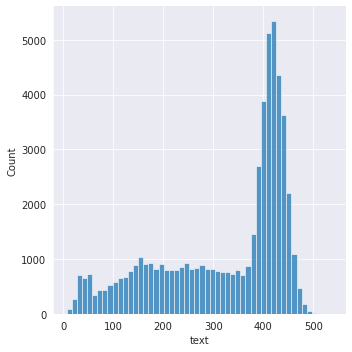

In [25]:
# Do a distribution plot on the seqquence length's of the given text
sns.set_style('darkgrid')
plt.figure.Figure(figsize=(16,10))
sns.displot(seqlen)

In [26]:
# Maximum length of the text we are going to train and predict here
SEQ_LEN = 100

## Encode Input Data
Encode the Input-Tensor and the Attention Tensor.

In [27]:
modelPath = '/gdrive/MyDrive/Colab Notebooks/Transformers/LocalModelUsage/distilbert-base-multilingual-cased/'
!ls {modelPath.replace(' ', '\ ')} -lha

total 1.3G
-rw------- 1 root root 1.3G Mar  8 18:56  distilbert-base-multilingual-cased.zip
-rw------- 1 root root 9.8K Mar  8 18:57 'Model Download Save.ipynb'
-rw------- 1 root root 102K Mar  8 19:17 'Model Load.ipynb'


In [28]:
!unzip {(modelPath+'distilbert-base-multilingual-cased.zip').replace(' ', '\ ')} -d localModel

Archive:  /gdrive/MyDrive/Colab Notebooks/Transformers/LocalModelUsage/distilbert-base-multilingual-cased/distilbert-base-multilingual-cased.zip
  inflating: localModel/distilbert-base-multilingual-cased/config.json  
  inflating: localModel/distilbert-base-multilingual-cased/pytorch_model.bin  
  inflating: localModel/distilbert-base-multilingual-cased/README.md  
  inflating: localModel/distilbert-base-multilingual-cased/tf_model.h5  
 extracting: localModel/distilbert-base-multilingual-cased/tokenizer_config.json  
  inflating: localModel/distilbert-base-multilingual-cased/tokenizer.json  
  inflating: localModel/distilbert-base-multilingual-cased/vocab.txt  


In [31]:
from transformers import AutoTokenizer
tranformersPreTrainedModelName = 'german-nlp-group/electra-base-german-uncased'
tokenizer = AutoTokenizer.from_pretrained(tranformersPreTrainedModelName) 

In [32]:
tokens = tokenizer.encode_plus('Hello World'
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')

In [33]:
# Outputs 2 tensors named 'input_ids' & 'attention_mask'
# The values 101 and 102 are start and end of sentence identifiers
# while 7592 & 2088 are tokens for 'Hello World'
#
# Attention Mask tells Bert which tokens to pay attention to and which to ompletely ignore
print (tokens)

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 9747, 1778, 8995,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0

### Tokenize each Sample in Dataset

In [34]:
import numpy as np
# initialize numpy arrays for Token-Ids and Attention Masks
Xids = np.zeros((len(df), SEQ_LEN), dtype=float)
Xmask = np.zeros((len(df), SEQ_LEN), dtype=float)

In [35]:
Xids.shape

(56609, 100)

In [36]:
# Use a simple for loop to encode all data points
for i, sequence in enumerate(df['text']):
  tokens = tokenizer.encode_plus(sequence
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')
  
  Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [37]:
# Array of tokenized Ids
Xids

array([[2.0000e+00, 2.5980e+03, 1.7467e+04, ..., 1.0011e+04, 1.3608e+04,
        3.0000e+00],
       [2.0000e+00, 2.5330e+03, 4.1810e+03, ..., 6.0760e+03, 2.8590e+03,
        3.0000e+00],
       [2.0000e+00, 2.5270e+03, 1.9221e+04, ..., 7.7900e+02, 1.7440e+04,
        3.0000e+00],
       ...,
       [2.0000e+00, 5.9900e+03, 2.5520e+03, ..., 1.7680e+03, 2.5325e+04,
        3.0000e+00],
       [2.0000e+00, 9.4450e+03, 1.8228e+04, ..., 6.6380e+03, 6.6380e+03,
        3.0000e+00],
       [2.0000e+00, 6.7650e+03, 3.1116e+04, ..., 3.0370e+03, 7.7190e+03,
        3.0000e+00]])

In [38]:
# Array of attaention masks
Xmask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [39]:
print (type(Xids))
print (type(Xmask))
print (type(labels))
print (type(labels[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Save Tokenized Data

In [40]:
with open ('xids.npy', 'wb') as f:
  np.save(f, Xids)
with open ('xmask.npy', 'wb') as f:
  np.save(f, Xmask)
with open ('labels.npy', 'wb') as f:
  np.save(f, labels)

del df, Xids, Xmask, labels
df = None

## Ininitializing Hugging Face Tokenizer and Model

### Load Tokenized Data

In [41]:
import numpy as np
with open ('xids.npy', 'rb') as f:
  Xids = np.load(f)
with open ('xmask.npy', 'rb') as f:
  Xmask = np.load(f)
with open ('labels.npy', 'rb') as f:
  labels = np.load(f)

In [42]:
Xids

array([[2.0000e+00, 2.5980e+03, 1.7467e+04, ..., 1.0011e+04, 1.3608e+04,
        3.0000e+00],
       [2.0000e+00, 2.5330e+03, 4.1810e+03, ..., 6.0760e+03, 2.8590e+03,
        3.0000e+00],
       [2.0000e+00, 2.5270e+03, 1.9221e+04, ..., 7.7900e+02, 1.7440e+04,
        3.0000e+00],
       ...,
       [2.0000e+00, 5.9900e+03, 2.5520e+03, ..., 1.7680e+03, 2.5325e+04,
        3.0000e+00],
       [2.0000e+00, 9.4450e+03, 1.8228e+04, ..., 6.6380e+03, 6.6380e+03,
        3.0000e+00],
       [2.0000e+00, 6.7650e+03, 3.1116e+04, ..., 3.0370e+03, 7.7190e+03,
        3.0000e+00]])

In [43]:
for i in range(0, 20):
  print(labels[i])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
import tensorflow as tf
#tf.config.list_physical_device('GPU')

In [45]:
# TensorFlow expects input and target labels as an input tuple
# Bert expects a dictionary of 'input_ids' and 'attention_mask' as input
# So, lets create the dataset object
# This creates a generator for a tuple of input tokens, attention_masks, and target labels
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [46]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ((100,), (100,), (9,)), types: (tf.float64, tf.float64, tf.float64)>

(<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([2.0000e+00, 2.5980e+03, 1.7467e+04, 1.7790e+03, 3.4340e+03,
       2.6470e+03, 2.5440e+03, 3.5320e+03, 5.4640e+03, 5.3820e+03,
       7.3170e+03, 6.8120e+03, 2.6050e+03, 2.5900e+03, 1.8610e+04,
       1.7750e+03, 4.1980e+03, 7.8000e+02, 2.6400e+03, 4.1390e+03,
       2.7680e+03, 5.5110e+03, 1.6692e+04, 2.5270e+03, 3.1530e+03,
       3.5630e+03, 1.7700e+03, 7.7900e+02, 6.5640e+03, 2.9410e+03,
       2.5190e+03, 2.5440e+03, 6.3650e+03, 8.3410e+03, 3.1040e+03,
       1.1573e+04, 8.4330e+03, 7.8000e+02, 3.3620e+03, 2.5440e+03,
       4.4300e+03, 2.6600e+03, 3.6450e+03, 4.8280e+03, 2.7160e+03,
       2.6260e+03, 2.5270e+03, 3.3190e+03, 2.5330e+03, 3.5080e+03,
       2.6258e+04, 1.7670e+03, 1.7680e+03, 2.5900e+03, 6.1730e+03,
       3.4130e+03, 7.8000e+02, 8.3060e+03, 2.6890e+03, 3.6660e+03,
       2.8250e+03, 2.6600e+03, 2.4876e+04, 2.5420e+03, 3

In [47]:
# minute 21:55
# TensorFlow Bert model expects our input in a Tuple format containing:
# 1) 'input_ids' and 'attention_mask' in a Dictionary and
# 2) a label as 2nd part of the tupel
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [48]:
# we can use the dataset map function to apply this format
dataset = dataset.map(map_func)

In [49]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ({input_ids: (100,), attention_mask: (100,)}, (9,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

({'input_ids': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([2.0000e+00, 2.5980e+03, 1.7467e+04, 1.7790e+03, 3.4340e+03,
       2.6470e+03, 2.5440e+03, 3.5320e+03, 5.4640e+03, 5.3820e+03,
       7.3170e+03, 6.8120e+03, 2.6050e+03, 2.5900e+03, 1.8610e+04,
       1.7750e+03, 4.1980e+03, 7.8000e+02, 2.6400e+03, 4.1390e+03,
       2.7680e+03, 5.5110e+03, 1.6692e+04, 2.5270e+03, 3.1530e+03,
       3.5630e+03, 1.7700e+03, 7.7900e+02, 6.5640e+03, 2.9410e+03,
       2.5190e+03, 2.5440e+03, 6.3650e+03, 8.3410e+03, 3.1040e+03,
       1.1573e+04, 8.4330e+03, 7.8000e+02, 3.3620e+03, 2.5440e+03,
       4.4300e+03, 2.6600e+03, 3.6450e+03, 4.8280e+03, 2.7160e+03,
       2.6260e+03, 2.5270e+03, 3.3190e+03, 2.5330e+03, 3.5080e+03,
       2.6258e+04, 1.7670e+03, 1.7680e+03, 2.5900e+03, 6.1730e+03,
       3.4130e+03, 7.8000e+02, 8.3060e+03, 2.6890e+

In [50]:
# SHuffle and Bach Dataset
#dataset = dataset.shuffle(1000).batch(32)

In [51]:
# Get the total size of dataset now that it is batched
#
# the dataset object is a generator object so we cannot take the length of it directly
# thus, we have to convert it into a list
# 
# Do not do this with a very large dataset
#
DS_LEN = len(list(dataset))
DS_LEN

56609

In [52]:
print (f"Alternative Computation for DS_LEN: {len(Xids)/32} -> {round(len(Xids)/32, 0)}")

Alternative Computation for DS_LEN: 1769.03125 -> 1769.0


In [53]:
SPLIT = .8

# take or skip the specified number of batches to split by factor
test = dataset.skip(round(DS_LEN * SPLIT)).batch(32)
trainevalu = dataset.take(round(DS_LEN * SPLIT))

DS_LEN2 = len(list(trainevalu))

train = trainevalu.take(round(DS_LEN2 * SPLIT)).shuffle(1000).batch(32)
evalu = trainevalu.skip(round(DS_LEN2 * SPLIT)).shuffle(1000).batch(32)

del dataset

In [54]:
print (f"test data: {len(test)}")
print (f"train data: {len(train)}, train evalu data: {len(evalu)}")

test data: 354
train data: 1133, train evalu data: 284


## Build Model

In [56]:
from transformers import BertConfig
bertConfig = BertConfig.from_pretrained(tranformersPreTrainedModelName
                                        , output_hidden_states=True
                                        , num_lables=6
                                        , max_length=SEQ_LEN
                                        , label2id=label2index
                                        , id2label=index2label
                                        )

In [58]:
from transformers import TFBertForSequenceClassification
bert = TFBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config=bertConfig, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['electra.encoder.layer.1.attention.output.dense.weight', 'electra.encoder.layer.5.attention.output.dense.bias', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.0.intermediate.dense.weight', 'electra.encoder.layer.7.attention.self.key.bias', 'electra.encoder.layer.8.attention.self.query.bias', 'electra.encoder.layer.8.attention.self.value.weight', 'electra.encoder.layer.2.intermediate.dense.bias', 'electra.encoder.layer.5.attention.self.key.bias', 'electra.encoder.layer.10.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.output.dense.weight', 'electra.encoder.layer.4.intermediate.dense.weight', 'electra.encoder.layer.7.attention.self.value.weight', 'electra.encoder.layer.7.output.dense.weight', 'electra.encoder.layer.7.attention.self.query.bias', 'electra.encoder.layer.8.output.LayerNorm.bias', 'electra.embeddings.token_type_embeddin

In [59]:
bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  111206400 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  6921      
Total params: 111,213,321
Trainable params: 111,213,321
Non-trainable params: 0
_________________________________________________________________


In [60]:
# build 2 input layers to Bert Model where name needs to match the input values in the dataset
input_ids = tf.keras.Input(shape=(SEQ_LEN,), name = 'input_ids', dtype='int32')
mask = tf.keras.Input(shape=(SEQ_LEN,), name = 'attention_mask', dtype='int32')

embedings = bert.layers[0](input_ids, attention_mask=mask)[0]

#Original Author: Ferry Djaja
#https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
X = tf.keras.layers.Dropout(0.5)(embedings)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(X)
y = tf.keras.layers.Dense(len(label2index), activation='sigmoid', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)

# Freeze the Bert model by freezing this layer to make training less of an overkill in terms of required performance
model.layers[2].trainable = False

In [61]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 111206400   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 100, 768)     0           bert[0][13]                  

In [62]:
#
# https://stackoverflow.com/questions/52125924/why-does-sigmoid-crossentropy-of-keras-tensorflow-have-low-precision
# keras with custom loss function
def customLoss(target, output):
    # if not from_logits:
    #     # transform back to logits
    #     _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
    #     output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    #     output = tf.log(output / (1 - output))
    output = tf.math.log(output / (1 - output))
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
    loss=customLoss,
    optimizer=optimizer,
    metrics=['accuracy']
    )

#loss=tf.keras.losses.BinaryCrossentropy()
#optimizer = tf.keras.optimizers.Adam()  #lr=1e-3,  lr=0.001, decay=1e-6
#model.compile(
#    loss=loss,
#    optimizer=optimizer,
#    metrics=['accuracy']
#    )

In [63]:
from timeit import default_timer as timer
from datetime import timedelta
import os

start = timer()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=9, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    cp_callback
]

history = model.fit(train
                    , validation_data=evalu
                    , callbacks=callbacks, verbose=1
                    , epochs=32)

end = timer()
print(timedelta(seconds=end-start))

Epoch 1/32
1133/1133 [==============================] - 378s 301ms/step - loss: 0.2433 - accuracy: 0.4577 - val_loss: 0.3567 - val_accuracy: 0.1408

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/32
1133/1133 [==============================] - 338s 298ms/step - loss: 0.2482 - accuracy: 0.4527 - val_loss: 0.3595 - val_accuracy: 0.1330

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/32
1133/1133 [==============================] - 338s 298ms/step - loss: 0.2478 - accuracy: 0.4701 - val_loss: 0.3545 - val_accuracy: 0.1684

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/32
1133/1133 [==============================] - 337s 298ms/step - loss: 0.2464 - accuracy: 0.4775 - val_loss: 0.3566 - val_accuracy: 0.1933

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/32
1133/1133 [==============================] - 337s 298ms/step - loss: 0.2460 - accuracy: 0.4699 - val_loss: 0.3582 - val_accuracy: 0.1804

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/32
1133

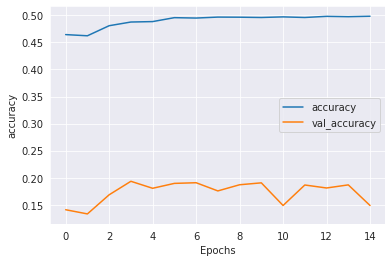

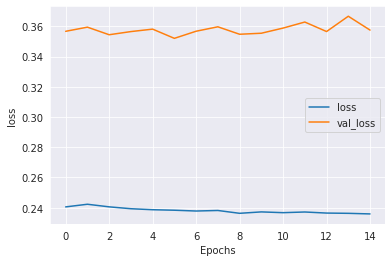

In [64]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaluation

In [65]:
results = model.evaluate(test, batch_size=32)
print("test loss, test acc:", results)

354/354 [==============================] - 77s 217ms/step - loss: 0.4397 - accuracy: 0.1434
test loss, test acc: [0.4396818280220032, 0.14343754947185516]


In [66]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 1 sample")
predictions = model.predict(test.take(1))
print("predictions shape:", predictions.shape)

Generate predictions for 1 sample
predictions shape: (32, 9)


In [67]:
threshold = .6

for item in test.take(1):
  #print (f"inputs: {item [0]}")
  print ()
  #print (f"labels: {item [1]}")
  countOK = 0
  countNOK = 0

  for i in range(len(predictions)):

    labelValues = item[1][i].numpy()
    for l in range(len(labelValues)):
      #print (f"labelValues: {labelValues[l]} predictions: {predictions[1][l]}")
      if (labelValues[l] == 1. and predictions[1][l] > threshold):
        print (f"1  OK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        countOK = countOK + 1
      elif (labelValues[l] == 1. and predictions[1][l] <= threshold):
        print (f"2 NOK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        countNOK = countNOK + 1
      elif (labelValues[l] == 0. and predictions[1][l] > threshold):
        print (f"3 NOK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        #countNOK = countNOK + 1
      #elif (labelValues[l] == 0. and predictions[1][l] <= threshold):
        #print (f"4  OK Actual label: {index2label[l]} NOT predicted with score: {format(predictions[1][l], '.6f')}")
        #countOK = countOK + 1

    print ()

  sumCount = countNOK+countOK
  print (f"OK + NOK: {format(sumCount, '3d')}")
  if sumCount > 0:
    print (f"      OK: {format(countOK, '3d')} ->  True: {format(((countOK/sumCount)*100), '.3f')}%")
    print (f"     NOK: {format(countNOK, '3d')} -> False: {format(((countNOK/sumCount)*100), '.3f')}%")



2 NOK Actual label: Politik predicted with score: 0.118092

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Politik predicted with score: 0.118092

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Politik predicted with score: 0.118092

2 NOK Actual label: Politik predicted with score: 0.118092

2 NOK Actual label: Panorama predicted with score: 0.004736

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Sport predicted with score: 0.129357

2 NOK Actual label: Politik predicted with score: 0.118092



In [68]:
!ls training_1/ -lh

total 449M
-rw-r--r-- 1 root root   71 Mar 19 19:25 checkpoint
-rw-r--r-- 1 root root 449M Mar 19 19:25 cp.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root  17K Mar 19 19:25 cp.ckpt.index
